## Kaggle Housing Prices
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
#Loading libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('----------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

In [ ]:
#visualising missing values
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
sns.plt.show()

In [ ]:
#SalePrice
sns.distplot(train['SalePrice'])
print("The skewness of SalePrice is {}".format(train['SalePrice'].skew()))

In [ ]:
#now transforming the target variable
target = np.log(train['SalePrice'])
sns.distplot(target)
print ('Skewness is', target.skew())

In [ ]:
#separate variables into new data frames
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
del numeric_data['Id']
print("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

In [ ]:
#correlation plot
corr = numeric_data.corr()
sns.heatmap(corr)

In [ ]:
print (corr['SalePrice'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['SalePrice'].sort_values()[:5]) #last 5 values

#detailed OverallQual
train['OverallQual'].unique()

In [ ]:
#let's check the mean price per quality and plot it.
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
# Overall Quality - Median SalePrice
print(pivot.sort_values(by='SalePrice'))
pivot.plot(kind='bar', color='red')

In [ ]:
#GrLivArea variable
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])

In [ ]:
train[train['GrLivArea']>4000][['GrLivArea','SalePrice']]

In [ ]:
#TotalBsmtSF variable
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'])

In [ ]:
train[train['TotalBsmtSF']>3000][['TotalBsmtSF','SalePrice']]

In [ ]:
cat_data.describe()

In [ ]:
sp_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
print(sp_pivot)
sp_pivot.plot(kind='bar',color='red')

In [ ]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['SalePrice'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['SalePrice'] = train.SalePrice.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

In [ ]:
num = numeric_data.columns
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [ ]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in train.columns if train.dtypes[f] == 'object']

p = pd.melt(train, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value','SalePrice')
g

In [4]:
#removing outliers
train.drop(train[train['GrLivArea'] > 4000].index, inplace=True)
train.drop(train[train['TotalBsmtSF'] > 3000].index, inplace=True)

In [5]:
test.loc[666]
test.loc[666, 'GarageQual'] = "TA" #stats.mode(test['GarageQual']).mode
test.loc[666, 'GarageCond'] = "TA" #stats.mode(test['GarageCond']).mode
test.loc[666, 'GarageFinish'] = "Unf" #stats.mode(test['GarageFinish']).mode
test.loc[666, 'GarageYrBlt'] = "1980" #np.nanmedian(test['GarageYrBlt'])
#mark as missing
test.loc[1116, 'GarageType'] = np.nan

In [6]:
#importing function
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def factorize(data, var, fill_na = None):
      if fill_na is not None:
            data[var].fillna(fill_na, inplace=True)
      le.fit(data[var])
      data[var] = le.transform(data[var])
      return data

In [7]:
#combine the data set
alldata = train.append(test)

In [8]:
#impute lotfrontage by median of neighborhood
lot_frontage_by_neighborhood = train['LotFrontage'].groupby(train['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
                idx = (alldata['Neighborhood'] == key) & (alldata['LotFrontage'].isnull())
                alldata.loc[idx, 'LotFrontage'] = group.median()

In [9]:
#imputing missing values
alldata["MasVnrArea"].fillna(0, inplace=True)
alldata["BsmtFinSF1"].fillna(0, inplace=True)
alldata["BsmtFinSF2"].fillna(0, inplace=True)
alldata["BsmtUnfSF"].fillna(0, inplace=True)
alldata["TotalBsmtSF"].fillna(0, inplace=True)
alldata["GarageArea"].fillna(0, inplace=True)
alldata["BsmtFullBath"].fillna(0, inplace=True)
alldata["BsmtHalfBath"].fillna(0, inplace=True)
alldata["GarageCars"].fillna(0, inplace=True)
alldata["GarageYrBlt"].fillna(0.0, inplace=True)
alldata["PoolArea"].fillna(0, inplace=True)

In [10]:
qual_dict = {np.nan: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
name = np.array(['ExterQual','PoolQC' ,'ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu', 'GarageQual','GarageCond'])

for i in name:
     alldata[i] = alldata[i].map(qual_dict).astype(int)

alldata["BsmtExposure"] = alldata["BsmtExposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
alldata["BsmtFinType1"] = alldata["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
alldata["BsmtFinType2"] = alldata["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
alldata["Functional"] = alldata["Functional"].map({np.nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

alldata["GarageFinish"] = alldata["GarageFinish"].map({np.nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
alldata["Fence"] = alldata["Fence"].map({np.nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

#encoding data
alldata["CentralAir"] = (alldata["CentralAir"] == "Y") * 1.0
varst = np.array(['MSSubClass','LotConfig','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','Foundation','SaleCondition'])

for x in varst:
         factorize(alldata, x)

#encode variables and impute missing values
alldata = factorize(alldata, "MSZoning", "RL")
alldata = factorize(alldata, "Exterior1st", "Other")
alldata = factorize(alldata, "Exterior2nd", "Other")
alldata = factorize(alldata, "MasVnrType", "None")
alldata = factorize(alldata, "SaleType", "Oth")


In [11]:
#creating new variable (1 or 0) based on irregular count levels
#The level with highest count is kept as 1 and rest as 0
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

#Did the modeling happened during the sale year
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

#setting levels with high count as 1 and rest as 0
#you can check for them using value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [12]:
alldata.shape

(2912, 100)

In [13]:
#create alldata2
alldata2 = train.append(test)

alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# house completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

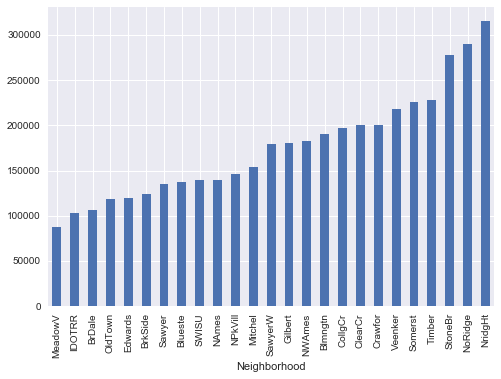

In [14]:
#calculating total area using all area columns
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]

alldata["TotalArea"] = alldata[area_cols].sum(axis=1)
alldata["TotalArea1st2nd"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]
alldata["Age"] = 2010 - alldata["YearBuilt"]
alldata["TimeSinceSold"] = 2010 - alldata["YrSold"]
alldata["SeasonSold"] = alldata["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
alldata["YearsSinceRemodel"] = alldata["YrSold"] - alldata["YearRemodAdd"]

# Simplifications of existing features into bad/average/good based on counts
alldata["SimplOverallQual"] = alldata.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplPoolQC"] = alldata.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
alldata["SimplGarageCond"] = alldata.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplGarageQual"] = alldata.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFunctional"] = alldata.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
alldata["SimplKitchenQual"] = alldata.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplHeatingQC"] = alldata.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtFinType1"] = alldata.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtFinType2"] = alldata.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtCond"] = alldata.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtQual"] = alldata.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterCond"] = alldata.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterQual"] = alldata.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

#grouping neighborhood variable based on this plot
train['SalePrice'].groupby(train['Neighborhood']).median().sort_values().plot(kind='bar')

In [15]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1,
                    "Sawyer" : 1, "Blueste" : 1, "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2, 
                    "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, 
                    "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3, "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, 
                    "NoRidge" : 4, "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)
alldata.loc[alldata2.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
alldata["Neighborhood_Good"].fillna(0, inplace=True)
alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
alldata.shape

(2912, 126)

In [17]:
cols = ['Alley','Condition2','Heating','LandContour','LandSlope','LotShape','PavedDrive', 'RoofMatl', 'Street']
cols = cols+['Electrical', 'GarageType','MiscFeature','Utilities']
alldata['GarageYrBlt'] = alldata['GarageYrBlt'].astype(int)
for i in cols:
    alldata[i] = alldata[i].astype(str)
    alldata = factorize(alldata,i)

In [44]:
#create new data
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print("Train: ", train_new.shape)
print ('----------------')
print("Test: ", test_new.shape)

Train:  (1453, 126)
----------------
Test:  (1459, 126)


In [45]:
#get numeric features
numeric_features = [f for f in train_new.columns if train_new[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = train_new[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
train_new[skewed] = np.log1p(train_new[skewed])
test_new[skewed] = np.log1p(test_new[skewed])
del test_new['SalePrice']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_new[numeric_features])
scaled = scaler.transform(train_new[numeric_features])

for i, col in enumerate(numeric_features):
       train_new[col] = scaled[:,i]

numeric_features.remove('SalePrice')
scaled = scaler.fit_transform(test_new[numeric_features])

for i, col in enumerate(numeric_features):
      test_new[col] = scaled[:,i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [47]:
def onehot(onehot_df, df, column_name, fill_na):
       onehot_df[column_name] = df[column_name]
       if fill_na is not None:
            onehot_df[column_name].fillna(fill_na, inplace=True)

       dummies = pd.get_dummies(onehot_df[column_name], prefix="_"+column_name)
       onehot_df = onehot_df.join(dummies)
       onehot_df = onehot_df.drop([column_name], axis=1)
       return onehot_df

def munge_onehot(df):
       onehot_df = pd.DataFrame(index = df.index)

       onehot_df = onehot(onehot_df, df, "MSSubClass", None)
       onehot_df = onehot(onehot_df, df, "MSZoning", "RL")
       onehot_df = onehot(onehot_df, df, "LotConfig", None)
       onehot_df = onehot(onehot_df, df, "Neighborhood", None)
       onehot_df = onehot(onehot_df, df, "Condition1", None)
       onehot_df = onehot(onehot_df, df, "BldgType", None)
       onehot_df = onehot(onehot_df, df, "HouseStyle", None)
       onehot_df = onehot(onehot_df, df, "RoofStyle", None)
       onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd")
       onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd")
       onehot_df = onehot(onehot_df, df, "Foundation", None)
       onehot_df = onehot(onehot_df, df, "SaleType", "WD")
       onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal")

       #Fill in missing MasVnrType for rows that do have a MasVnrArea.
       temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
       idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
       temp_df.loc[idx, "MasVnrType"] = "BrkFace"
       onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None")

       onehot_df = onehot(onehot_df, df, "LotShape", None)
       onehot_df = onehot(onehot_df, df, "LandContour", None)
       onehot_df = onehot(onehot_df, df, "LandSlope", None)
       onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr")
       onehot_df = onehot(onehot_df, df, "GarageType", "None")
       onehot_df = onehot(onehot_df, df, "PavedDrive", None)
       onehot_df = onehot(onehot_df, df, "MiscFeature", "None")
       onehot_df = onehot(onehot_df, df, "Street", None)
       onehot_df = onehot(onehot_df, df, "Alley", "None")
       onehot_df = onehot(onehot_df, df, "Condition2", None)
       onehot_df = onehot(onehot_df, df, "RoofMatl", None)
       onehot_df = onehot(onehot_df, df, "Heating", None)

       # we'll have these as numerical variables too
       onehot_df = onehot(onehot_df, df, "ExterQual", "None")
       onehot_df = onehot(onehot_df, df, "ExterCond", "None")
       onehot_df = onehot(onehot_df, df, "BsmtQual", "None")
       onehot_df = onehot(onehot_df, df, "BsmtCond", "None")
       onehot_df = onehot(onehot_df, df, "HeatingQC", "None")
       onehot_df = onehot(onehot_df, df, "KitchenQual", "TA")
       onehot_df = onehot(onehot_df, df, "FireplaceQu", "None")
       onehot_df = onehot(onehot_df, df, "GarageQual", "None")
       onehot_df = onehot(onehot_df, df, "GarageCond", "None")
       onehot_df = onehot(onehot_df, df, "PoolQC", "None")
       onehot_df = onehot(onehot_df, df, "BsmtExposure", "None")
       onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None")
       onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None")
       onehot_df = onehot(onehot_df, df, "Functional", "Typ")
       onehot_df = onehot(onehot_df, df, "GarageFinish", "None")
       onehot_df = onehot(onehot_df, df, "Fence", "None")
       onehot_df = onehot(onehot_df, df, "MoSold", None)

       # Divide  the years between 1871 and 2010 into slices of 20 years
       year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20))  for i in range(0, 7))
       yearbin_df = pd.DataFrame(index = df.index)
       yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
       yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)
       yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
       yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)

       onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None)
       onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None)
       onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None)
       return onehot_df

#create one-hot features
onehot_df = munge_onehot(train)

neighborhood_train = pd.DataFrame(index=train_new.shape)
neighborhood_train['NeighborhoodBin'] = train_new['NeighborhoodBin']
neighborhood_test = pd.DataFrame(index=test_new.shape)
neighborhood_test['NeighborhoodBin'] = test_new['NeighborhoodBin']

onehot_df = onehot(onehot_df, neighborhood_train, 'NeighborhoodBin', None)

In [48]:
train_new = train_new.join(onehot_df) 
train_new.shape

(1453, 433)

In [49]:
#adding one hot features to test
onehot_df_te = munge_onehot(test)
onehot_df_te = onehot(onehot_df_te, neighborhood_test, "NeighborhoodBin", None)
test_new = test_new.join(onehot_df_te)
test_new.shape

(1459, 417)

In [50]:
drop_cols = ["_Exterior1st_ImStucc", "_Exterior1st_Stone","_Exterior2nd_Other","_HouseStyle_2.5Fin","_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll", "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn", "_Heating_Floor", "_Heating_OthW", "_Electrical_Mix", "_MiscFeature_TenC", "_GarageQual_Ex",  "_PoolQC_Fa"]
train_new.drop(drop_cols, axis=1, inplace=True)
train_new.shape

(1453, 417)

In [51]:
#removing one column missing from train data
test_new.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns
drop_cols = ["_Condition2_PosN", # only two are not zero
         "_MSZoning_C (all)",
         "_MSSubClass_160"]

train_new.drop(drop_cols, axis=1, inplace=True)
test_new.drop(drop_cols, axis=1, inplace=True)

In [56]:
label_df = pd.DataFrame(index = train_new.index, columns = ['SalePrice'])
label_df['SalePrice'] = np.log(train['SalePrice'])

In [71]:
test_new = test_new[train_new.columns]
print("Training set size:", train_new.shape)
print("Test set size:", test_new.shape)

Training set size: (1453, 412)
Test set size: (1459, 412)


In [72]:
import xgboost as xgb
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                       gamma=0.0,
                       learning_rate=0.05,
                       max_depth=6,
                       min_child_weight=1.5,
                       n_estimators=7200,
                       reg_alpha=0.9,
                       reg_lambda=0.6,
                       subsample=0.2,
                       seed=42,
                       silent=1)

regr.fit(train_new, label_df)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.05,
       max_delta_step=0, max_depth=6, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1,
       seed=42, silent=1, subsample=0.2)

In [73]:
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train_new)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_pred))
# make prediction on test set.
y_pred_xgb = regr.predict(test_new)

#submit this prediction and get the score
pred1 = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(y_pred_xgb)})
pred1.to_csv('xgbnono.csv', header=True, index=False)

XGBoost score on training set:  0.0374675028845


In [83]:
label_df = np.array(label_df['SalePrice'])

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_new,label_df,test_size = 0.7)

In [85]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, y_train)
dval = lgb.Dataset(X_test, y_test)

In [114]:
params = {
    
    'num_leaves' : 64,
    'learning_rate':0.001,
    'metric':'rmse',
    'max_depth':5,
}

In [ ]:
clf_lgb = lgb.train(params, dtrain,num_boost_round=10000,valid_sets=(dtrain,dval),verbose_eval=100)

[100]	training's rmse: 0.362777	valid_1's rmse: 0.36977
[200]	training's rmse: 0.336337	valid_1's rmse: 0.345635
[300]	training's rmse: 0.31256	valid_1's rmse: 0.324251
[400]	training's rmse: 0.29105	valid_1's rmse: 0.305207
[500]	training's rmse: 0.271814	valid_1's rmse: 0.288244
[600]	training's rmse: 0.254521	valid_1's rmse: 0.273141
[700]	training's rmse: 0.238942	valid_1's rmse: 0.259767
[800]	training's rmse: 0.224546	valid_1's rmse: 0.247582
[900]	training's rmse: 0.211624	valid_1's rmse: 0.236331
[1000]	training's rmse: 0.200034	valid_1's rmse: 0.226222
[1100]	training's rmse: 0.189576	valid_1's rmse: 0.217097
[1200]	training's rmse: 0.179635	valid_1's rmse: 0.208834
[1300]	training's rmse: 0.17059	valid_1's rmse: 0.201171
[1400]	training's rmse: 0.162305	valid_1's rmse: 0.194103
[1500]	training's rmse: 0.154761	valid_1's rmse: 0.187801
[1600]	training's rmse: 0.147978	valid_1's rmse: 0.182217
[1700]	training's rmse: 0.141947	valid_1's rmse: 0.177207
[1800]	training's rmse: 0.1

In [92]:
# make prediction on test set.
y_pred_lgb = clf_lgb.predict(test_new)

In [95]:

#submit this prediction and get the score
pred1 = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(y_pred_lgb)})
pred1.to_csv('lgbnono.csv', header=True, index=False)

In [97]:
from sklearn.linear_model import Lasso

#Found this best alpha through cross-validation.
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_new, label_df)

# Run prediction on the training set to get a rough idea of how well it does.
y_pred = regr.predict(train_new)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred))

Lasso score on training set:  0.101362090699


In [99]:
#make prediction on the test set.
y_pred_lasso = regr.predict(test_new)
lasso_ex = np.exp(y_pred_lasso)
pred1 = pd.DataFrame({'Id': test['Id'], 'SalePrice': lasso_ex})
pred1.to_csv('lasso_model.csv', header=True, index=False)

In [101]:
y_pred = (y_pred_xgb + y_pred_lasso) / 2
y_pred = np.exp(y_pred)
pred_df = pd.DataFrame(y_pred, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('ensemble1.csv', header=True, index_label='Id')